In [29]:
from rubix.core.pipeline import RubixPipeline 
import os
config = {
    "pipeline":{"name": "calc_ifu"},
    
    "logger": {
        "log_level": "DEBUG",
        "log_file_path": None,
        "format": "%(asctime)s - %(name)s - %(levelname)s - %(message)s",
    },
    "data": {
        "name": "IllustrisAPI",
        "args": {
            "api_key": os.environ.get("ILLUSTRIS_API_KEY"),
            "particle_type": ["stars"],
            "simulation": "TNG50-1",
            "snapshot": 99,
            "save_data_path": "data",
        },
        
        "load_galaxy_args": {
        "id": 14,
        "reuse": True,
        },
        
        "subset": {
            "use_subset": True,
            "subset_size": 10000,
        },
    },
    "simulation": {
        "name": "IllustrisTNG",
        "args": {
            "path": "data/galaxy-id-14.hdf5",
        },
    
    },
    "output_path": "output",

    "telescope":
        {"name": "MUSE"},
    "cosmology":
        {"name": "PLANCK15"},
        
    "galaxy":
        {"dist_z": 0.1},
        
    "ssp": {
        "template": {
            "name": "BruzualCharlot2003"
        },
    },        
}

pipe = RubixPipeline(config)

data= pipe.run()

/home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/factory.py:21: UserWarning: No telescope config provided, using default stored in /home/ufuk/Dokumente/Research/Masterarbeit/rubix/rubix/telescope/telescopes.yaml
  warnings.warn(
2024-05-22 11:20:24,718 - rubix - INFO - Getting rubix data...
2024-05-22 11:20:24,718 - rubix - INFO - Rubix galaxy file already exists, skipping conversion
2024-05-22 11:20:24,772 - rubix - WARNING - The Subset value is set in config. Using only subset of size 10000
2024-05-22 11:20:24,773 - rubix - INFO - Data loaded with 10000 particles.
2024-05-22 11:20:24,773 - rubix - DEBUG - Data Shape: {'coords': (10000, 3), 'velocities': (10000, 3), 'metallicity': (10000,), 'mass': (10000,), 'age': (10000,)}
2024-05-22 11:20:24,796 - rubix - INFO - Setting up the pipeline...
2024-05-22 11:20:24,797 - rubix - DEBUG - Pipeline Configuration: {'Transformers': {'rotate_galaxy': {'name': 'rotate_galaxy', 'depends_on': None, 'args': [], 'kwargs': {'type': 'f

rotating galaxy:  face-on


2024-05-22 11:20:25,240 - rubix - DEBUG - Calculation Finished! Spectra shape: (1, 10000, 842)
2024-05-22 11:20:25,241 - rubix - INFO - Scaling Spectra by Mass...
2024-05-22 11:20:25,244 - rubix - DEBUG - Doppler Shifted SSP Wave: (1, 10000, 842)
2024-05-22 11:20:25,244 - rubix - DEBUG - Telescope Wave Seq: (3721,)
2024-05-22 11:20:26,533 - rubix - INFO - Pipeline run completed in 1.74 seconds.


(1, 10000, 3721)


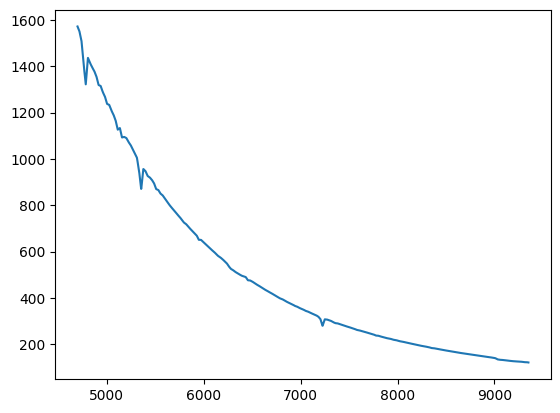

In [30]:
import matplotlib.pyplot as plt
wave = pipe.telescope.wave_seq
spectra = data["spectra"] # Spectra of all stars
print(spectra.shape)

plt.plot(wave, spectra[0,3]) 


Some of the spectra may be zero, this happens if the metallicity or age values are outside the range of the SSP model. This is currently the expected behavior

In [31]:
import jax 
import jax.numpy as jnp
# Create a function to calculate a single IFU cube
def calculate_ifu_cube(stars_spectra, pixel_indices):
    # Create an IFU cube of shape (25*25, 842)
    #ifu_cube = jnp.zeros((25 * 25, 842))
    
    # Use jax.ops.segment_sum to sum the spectra into the IFU cube based on pixel indices
    ifu_cube = jax.ops.segment_sum(stars_spectra, pixel_indices, num_segments=25*25)
    
    # Reshape the IFU cube to the desired shape (25, 25, 842)
    ifu_cube = ifu_cube.reshape((25, 25, 3721))
    
    return ifu_cube

spectra = data["spectra"]
assignments = data["pixel_assignment"]

# Calculate 4 individual IFU cubes
ifu_cubes = jax.vmap(calculate_ifu_cube)(spectra, assignments)

# Sum the 4 IFU cubes
final_ifu_cube = jnp.sum(ifu_cubes, axis=0)
final_ifu_cube.shape

(25, 25, 3721)

In [32]:

wavelengths = pipe.telescope.wave_seq

# get the indices of the visible wavelengths of 4000-8000 Angstroms

visible_indices = jnp.where((wavelengths >= 4000) & (wavelengths <= 8000))



In [33]:
wavelengths

Array([4700.15, 4701.4 , 4702.65, ..., 9347.65, 9348.9 , 9350.15],      dtype=float32)

In [34]:
spectra[0,7]

Array([0.62490237, 0.621853  , 0.6188036 , ..., 1.0887253 , 1.0866115 ,
       1.0844976 ], dtype=float32)

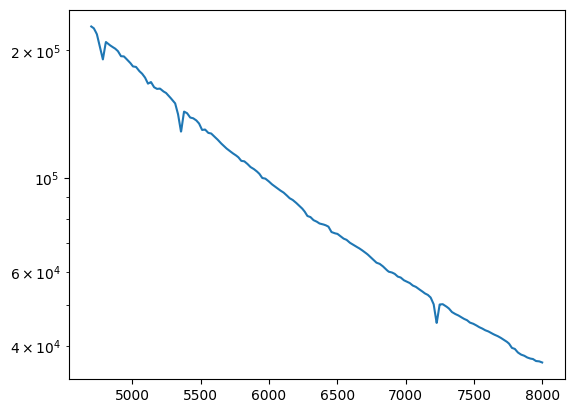

In [35]:
# plot example spectrum
import matplotlib.pyplot as plt

spec = final_ifu_cube[12, 12]

plt.plot(wavelengths[visible_indices], spec[visible_indices])
plt.yscale("log")

In [36]:
# get the spectra of the visible wavelengths from the ifu cube
visible_spectra = final_ifu_cube[:, :, visible_indices[0]]
visible_spectra.shape

(25, 25, 2640)

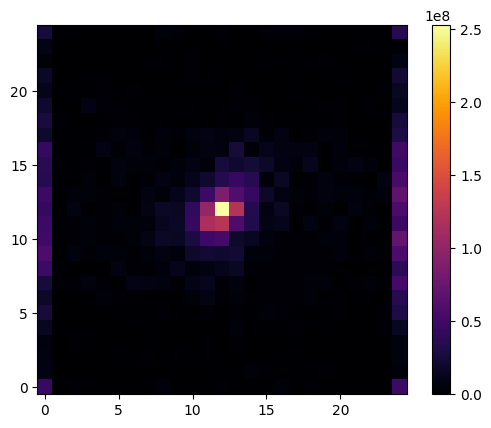

In [37]:
# Sum up all spectra to create an image
image = jnp.sum(visible_spectra, axis = 2)
plt.imshow(image, origin="lower", cmap="inferno")
plt.colorbar()